# Code Similarity: A Machine Learning Project

## Project Inicialization

In [1]:
import json, time, os
from parser.parser import *
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

PROJECTS_FOLDER = f'{os.getcwd()}/Projects/'

DATA_FOLDER = f'{os.getcwd()}/data/'

os.makedirs(DATA_FOLDER, exist_ok=True)

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


## Extrayendo Los AST

In [2]:

PROJECTS_FOLDER = f'{os.getcwd()}/Projects/'

DATA_FOLDER = f'{os.getcwd()}/data/'

os.makedirs(DATA_FOLDER, exist_ok=True)

project_features = []

for f in os.scandir(PROJECTS_FOLDER):
    if f.is_dir():
        print(PROJECTS_FOLDER + f.name)
        
        features = process_project(PROJECTS_FOLDER + f.name)
        features['project_name'] = f.name
        project_features.append(features)

# Generar un nombre de archivo JSON único usando la marca de tiempo
timestamp = time.strftime("%Y%m%d-%H%M%S")
output_json_path = os.path.join(DATA_FOLDER, f"features_{timestamp}.json")

# Guardar los features en un archivo JSON
with open(output_json_path, 'w', encoding='utf-8') as json_file:
    json.dump(project_features, json_file, ensure_ascii=False, indent=4)
  

/home/chony/Escritorio/tesis/Tesis/Projects/n-omino-main
/home/chony/Escritorio/tesis/Tesis/Projects/Second_Project_Dominoes-main
/home/chony/Escritorio/tesis/Tesis/Projects/Domino-master
/home/chony/Escritorio/tesis/Tesis/Projects/Dominoes-main
/home/chony/Escritorio/tesis/Tesis/Projects/Dommie-main
/home/chony/Escritorio/tesis/Tesis/Projects/Domino-main
/home/chony/Escritorio/tesis/Tesis/Projects/moogle-main
/home/chony/Escritorio/tesis/Tesis/Projects/DominoGame-main
/home/chony/Escritorio/tesis/Tesis/Projects/Proyecto-Domino--master
/home/chony/Escritorio/tesis/Tesis/Projects/Domino-Project-master
/home/chony/Escritorio/tesis/Tesis/Projects/DominoPlayer-master
/home/chony/Escritorio/tesis/Tesis/Projects/Domino-Project-Domino
/home/chony/Escritorio/tesis/Tesis/Projects/Proyecto-de-Pro-main
/home/chony/Escritorio/tesis/Tesis/Projects/Proyect-MATCOM-main
/home/chony/Escritorio/tesis/Tesis/Projects/Proyecto-Programacion-Mad-Kev-main
/home/chony/Escritorio/tesis/Tesis/Projects/MachiDomin

## Features Extraídos y su Importancia:

1. **`total_nodes`**
   - **Descripción**: Número total de nodos visitados en el árbol de sintaxis.
   - **Importancia**: Indica el tamaño del código fuente y la complejidad general del análisis.

2. **`node_count`**
   - **Descripción**: Diccionario que mantiene el conteo de cada tipo de nodo encontrado.
   - **Importancia**: Permite identificar qué tipos de constructos de lenguaje se utilizan más frecuentemente.

3. **`max_depth`**
   - **Descripción**: Profundidad máxima alcanzada en el árbol de sintaxis.
   - **Importancia**: Una mayor profundidad puede indicar una estructura de código más compleja y anidada.

4. **`variables`**
   - **Descripción**: Número de variables declaradas en el código.
   - **Importancia**: Indica la cantidad de almacenamiento local usado, lo cual puede reflejar la complejidad del estado manejado por el programa.

5. **`constants`**
   - **Descripción**: Número de constantes declaradas.
   - **Importancia**: Las constantes pueden indicar valores inmutables importantes y buenas prácticas de programación.

6. **`out_variables`**
   - **Descripción**: Número de variables de salida (out) declaradas.
   - **Importancia**: Las variables de salida son importantes para el flujo de datos y la gestión de resultados en métodos.

7. **`methods`**
   - **Descripción**: Número de métodos definidos.
   - **Importancia**: Ayuda a medir la modularidad y el tamaño funcional del código.

8. **`classes`**
   - **Descripción**: Número de clases definidas.
   - **Importancia**: Permite entender la estructura orientada a objetos del código.

9. **`interfaces`**
   - **Descripción**: Número de interfaces definidas.
   - **Importancia**: Las interfaces son cruciales para la abstracción y la definición de contratos en programación orientada a objetos.

10. **`abstract_classes`**
    - **Descripción**: Número de clases abstractas definidas.
    - **Importancia**: Las clases abstractas indican puntos de extensión y abstracción.

11. **`sealed_classes`**
    - **Descripción**: Número de clases selladas definidas.
    - **Importancia**: Las clases selladas indican clases que no pueden ser heredadas, lo cual puede ser útil para seguridad y optimización.

12. **`import_statements`**
    - **Descripción**: Número de declaraciones de importación (`using`).
    - **Importancia**: Refleja las dependencias y bibliotecas externas utilizadas en el código.

13. **`function_calls`**
    - **Descripción**: Número de llamadas a funciones.
    - **Importancia**: Indica el uso y la frecuencia de las funciones en el código.

14. **`try_catch_blocks`**
    - **Descripción**: Número de bloques try-catch.
    - **Importancia**: Refleja el manejo de excepciones y la robustez del código ante errores.

15. **`lists`**
    - **Descripción**: Número de listas utilizadas en el código.
    - **Importancia**: Las listas son estructuras de datos importantes y su uso puede indicar la gestión de colecciones.

16. **`dicts`**
    - **Descripción**: Número de diccionarios utilizados en el código.
    - **Importancia**: Los diccionarios son estructuras de datos importantes para el almacenamiento de pares clave-valor.

17. **`variable_names`**
    - **Descripción**: Conjunto de nombres de variables únicas.
    - **Importancia**: Ayuda a la identificación y análisis de la nomenclatura y la reutilización de nombres.

18. **`method_names`**
    - **Descripción**: Conjunto de nombres de métodos únicos.
    - **Importancia**: Útil para la identificación y análisis de la nomenclatura de métodos.

19. **`method_lengths`**
    - **Descripción**: Lista con la longitud de cada método.
    - **Importancia**: Métodos más largos pueden ser más complejos y difíciles de mantener.

20. **`class_names`**
    - **Descripción**: Conjunto de nombres de clases únicas.
    - **Importancia**: Ayuda a la identificación y análisis de la nomenclatura de clases.

21. **`interface_names`**
    - **Descripción**: Conjunto de nombres de interfaces únicas.
    - **Importancia**: Útil para la identificación y análisis de la nomenclatura de interfaces.

22. **`enum_names`**
    - **Descripción**: Conjunto de nombres de enumeraciones únicas.
    - **Importancia**: Mejora la legibilidad y la mantenibilidad del código, indicando constantes relacionadas.

23. **`delegate_names`**
    - **Descripción**: Conjunto de nombres de delegados únicos.
    - **Importancia**: Facilita la comprensión y el seguimiento de las referencias de métodos pasados como argumentos.

24. **`distinct_tokens`**
    - **Descripción**: Diccionario de tokens distintos y su conteo.
    - **Importancia**: Permite comprender la diversidad y la frecuencia de los tokens utilizados en el código.

25. **`control_structures`**
    - **Descripción**: Diccionario que cuenta las estructuras de control (`if`, `switch`, `for`, `while`, `dowhile`).
    - **Importancia**: Ayuda a entender el flujo lógico y las decisiones en el código.

26. **`access_modifiers_methods`**
    - **Descripción**: Diccionario que cuenta los modificadores de acceso en métodos (`public`, `private`, `protected`, etc.).
    - **Importancia**: Los modificadores indican la visibilidad y el control de acceso de los métodos, crucial para la encapsulación y la seguridad del código.

27. **`other_modifiers`**
    - **Descripción**: Diccionario que cuenta otros modificadores (`readonly`, `volatile`, `virtual`, `override`, etc.).
    - **Importancia**: Indican comportamientos especiales de métodos y variables, afectando la semántica y optimización del código.

28. **`library_calls`**
    - **Descripción**: Diccionario que cuenta las llamadas a ciertas bibliotecas (`Console`, `Math`).
    - **Importancia**: Refleja el uso de bibliotecas estándar y puede indicar dependencias clave en el código.

29. **`linq_queries`**
    - **Descripción**: Diccionario que cuenta las diferentes consultas LINQ utilizadas (`Select`, `Where`, `OrderBy`, etc.).
    - **Importancia**: LINQ es una característica poderosa en C# para manejar colecciones y datos, y su uso puede indicar un enfoque funcional en el código.

30. **`method_return_types`**
    - **Descripción**: Diccionario que almacena los tipos de retorno de los métodos.
    - **Importancia**: Permite comprender los tipos de datos devueltos por los métodos, lo cual es crucial para el análisis de tipos y la comprensión del flujo de datos.

31. **`method_parameters`**
    - **Descripción**: Diccionario que almacena los parámetros de los métodos.
    - **Importancia**: Proporciona información sobre la firma de los métodos, ayudando a entender cómo se intercambian los datos en el programa.

32. **`number_of_enums`**
    - **Descripción**: Número de enumeraciones (enum) definidas.
    - **Importancia**: Los enums proporcionan una manera de definir conjuntos de constantes relacionadas, mejorando la legibilidad y la mantenibilidad del código.

33. **`number_of_delegates`**
    - **Descripción**: Número de delegados definidos.
    - **Importancia**: Los delegados son tipos que representan referencias a métodos, permitiendo pasar métodos como argumentos.  

34. **`number_of_lambdas`**
   - **Descripción**: Número de expresiones lambda utilizadas.
   - **Importancia**: Las expresiones lambda son una forma concisa de escribir métodos anónimos y son clave para la programación funcional y las consultas LINQ.

35. **`number_of_getters_setters`**
   - **Descripción**: Número de getters y setters definidos en propiedades.
   - **Importancia**: Los getters y setters controlan el acceso a los datos de una clase y son esenciales para la encapsulación y la validación de datos.

36. **`number_of_tuples`**
   - **Descripción**: Número de tuplas utilizadas.
   - **Importancia**: Las tuplas son útiles para devolver múltiples valores de un método y pueden simplificar la estructura de datos en el código.

37. **`number_of_namespaces`**
    - **Descripción**: Número de espacios de nombres definidos.
    - **Importancia**: Los espacios de nombres organizan el código en grupos lógicos y evitan conflictos de nombres.


## MOSS Baseline

## Data Visualization

In [3]:
data = pd.read_json('data/features_20240616-171243.json')
data

,total_nodes,node_count,max_depth,number_of_variables,number_of_constants,out_variables,ref_params,number_of_methods,number_of_classes,number_of_interfaces,...,linq_queries_sum,linq_queries_count,library_call_console,library_call_math,number_of_lambdas,number_of_getters,number_of_setters,number_of_tuples,number_of_namespaces,project_name
0,229579,"{'Compilation_unitContext': 148, 'Namespace_me...",9195,553,0,0,40,527,214,57,...,185,0,138,5,17,64,34,3,63,Domino-main
1,30529,"{'Compilation_unitContext': 19, 'Using_directi...",1302,82,0,0,0,60,31,6,...,32,0,42,0,5,2,6,0,18,Domino-master
2,60216,"{'Compilation_unitContext': 30, 'Using_directi...",1990,74,0,6,0,104,38,7,...,18,0,0,0,2,39,22,0,5,Domino-Project-Domino
3,31511,"{'Compilation_unitContext': 20, 'Namespace_mem...",1481,88,0,0,0,76,32,12,...,43,0,58,0,9,18,7,0,20,Domino-Project-master
4,56868,"{'Compilation_unitContext': 55, 'Using_directi...",2941,85,0,0,0,91,34,10,...,39,0,0,0,0,15,15,0,43,Dominoes-main
5,24273,"{'Compilation_unitContext': 13, 'Namespace_mem...",724,55,0,0,0,21,11,0,...,15,0,6,0,0,4,4,0,7,DominoGame-main
6,28721,"{'Compilation_unitContext': 12, 'Using_directi...",831,63,6,3,0,38,10,1,...,27,0,1,0,13,13,1,0,12,DominoPlayer-master
7,74286,"{'Compilation_unitContext': 45, 'Using_directi...",2903,260,0,0,3,115,41,4,...,60,0,29,1,33,91,54,0,44,Dommie-main
8,34962,"{'Compilation_unitContext': 21, 'Namespace_mem...",1401,79,0,0,0,53,14,6,...,43,0,31,0,0,14,0,0,15,MachiDomino-main
9,17572,"{'Compilation_unitContext': 16, 'Using_directi...",670,60,0,0,0,18,8,0,...,5,0,5,4,5,9,6,0,9,moogle-main


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_nodes,16.0,75729.4375,80140.636259,17572.0,30725.50,39607.5,71939.25,292900.0
max_depth,16.0,2524.3750,2396.108397,670.0,1184.25,1441.0,2912.50,9195.0
number_of_variables,16.0,145.1250,137.274360,51.0,71.25,86.5,136.75,553.0
number_of_constants,16.0,0.3750,1.500000,0.0,0.00,0.0,0.00,6.0
out_variables,16.0,1.0000,2.280351,0.0,0.00,0.0,0.00,7.0
ref_params,16.0,3.0000,9.939819,0.0,0.00,0.0,0.25,40.0
number_of_methods,16.0,119.0625,130.293243,18.0,51.50,77.0,108.25,527.0
number_of_classes,16.0,47.3125,56.385245,8.0,17.75,31.5,43.00,214.0
number_of_interfaces,16.0,11.1875,14.143167,0.0,4.75,6.0,11.25,57.0
number_of_abstract_classes,16.0,0.0000,0.000000,0.0,0.00,0.0,0.00,0.0


In [5]:
p = sns.pairplot(data)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 65 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   total_nodes                          16 non-null     int64 
 1   node_count                           16 non-null     object
 2   max_depth                            16 non-null     int64 
 3   number_of_variables                  16 non-null     int64 
 4   number_of_constants                  16 non-null     int64 
 5   out_variables                        16 non-null     int64 
 6   ref_params                           16 non-null     int64 
 7   number_of_methods                    16 non-null     int64 
 8   number_of_classes                    16 non-null     int64 
 9   number_of_interfaces                 16 non-null     int64 
 10  number_of_abstract_classes           16 non-null     int64 
 11  number_of_sealed_classes             16 non-nul

## K-Means (Clustering)

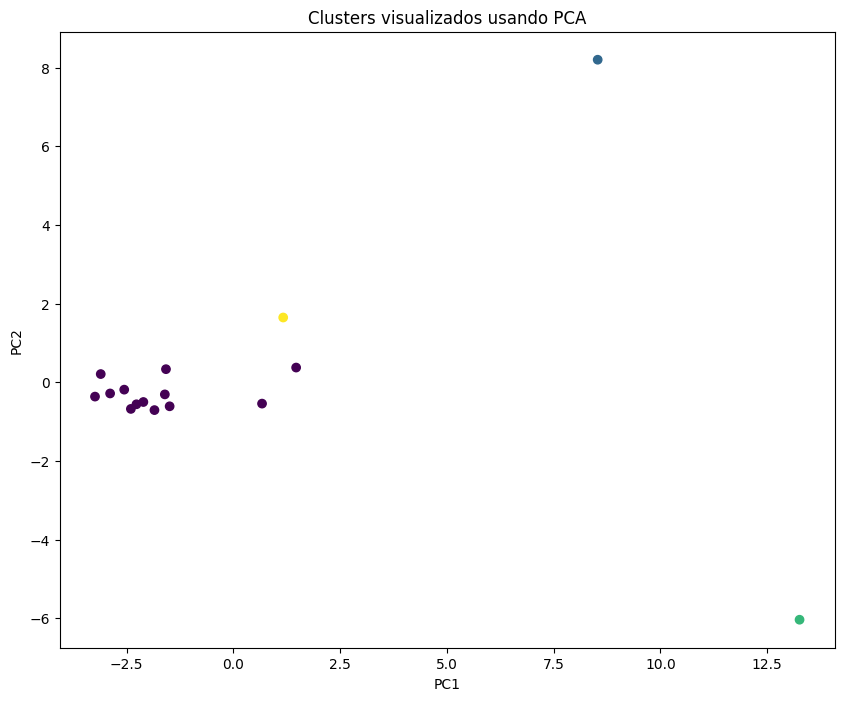

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Seleccionar columnas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Normalizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Definir el número de clusters
num_clusters = 4

# Crear y ajustar el modelo K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(scaled_data)

# Añadir las etiquetas de los clusters al DataFrame original
data['Cluster'] = kmeans.labels_

# Visualización usando PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Crear un DataFrame con los datos PCA
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans.labels_

# Plotear los clusters
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis', marker='o')
plt.title('Clusters visualizados usando PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Definir la arquitectura base
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Dense(128, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

# Definir la función de distancia
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# Crear el modelo de red siamesa
def create_siamese_network(input_shape):
    base_network = create_base_network(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Obtener las representaciones de las dos ramas
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Calcular la distancia euclidiana entre las representaciones
    distance = Lambda(euclidean_distance, output_shape=lambda x: (x[0], 1))([processed_a, processed_b])

    model = Model([input_a, input_b], distance)
    return model

# Definir la función de pérdida
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# Cargar y preparar los datos
def prepare_data():
    # Esto es solo un ejemplo con datos aleatorios
    # Debes reemplazarlo con tus datos reales de transacciones
    data_a = np.random.rand(1000, 30)
    data_b = np.random.rand(1000, 30)
    labels = np.random.randint(0, 2, size=(1000, 1))
    return data_a, data_b, labels

# Entrenar el modelo
def train_siamese_network():
    input_shape = (30,)
    model = create_siamese_network(input_shape)

    model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.001))

    data_a, data_b, labels = prepare_data()

    model.fit([data_a, data_b], labels, batch_size=128, epochs=20)

# Ejecutar el entrenamiento
if __name__ == "__main__":
    train_siamese_network()
